In [1]:
import sys
import os
from threading import Thread

import matplotlib.pyplot as plt
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit import transpile
from qiskit.circuit.library import Initialize

from q_alchemy_sdk_py.qiskit import QAlchemyInitialize

sys.path.append('..')
os.environ["Q_ALCHEMY_API_KEY"] = "<your api key>"

In [2]:
def plot_digits(digits, labels, text, matrix_dim):
    _, axes = plt.subplots(nrows=1, ncols=len(digits), figsize=(20, 10), squeeze=False)
    for ax, digit, label in zip(axes.reshape(-1), digits, labels):
        ax.set_axis_off()
        image = digit[:int(matrix_dim**2)].reshape(matrix_dim, matrix_dim)
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation='none')
        ax.set_title(label)

    plt.show()

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, parser="auto")

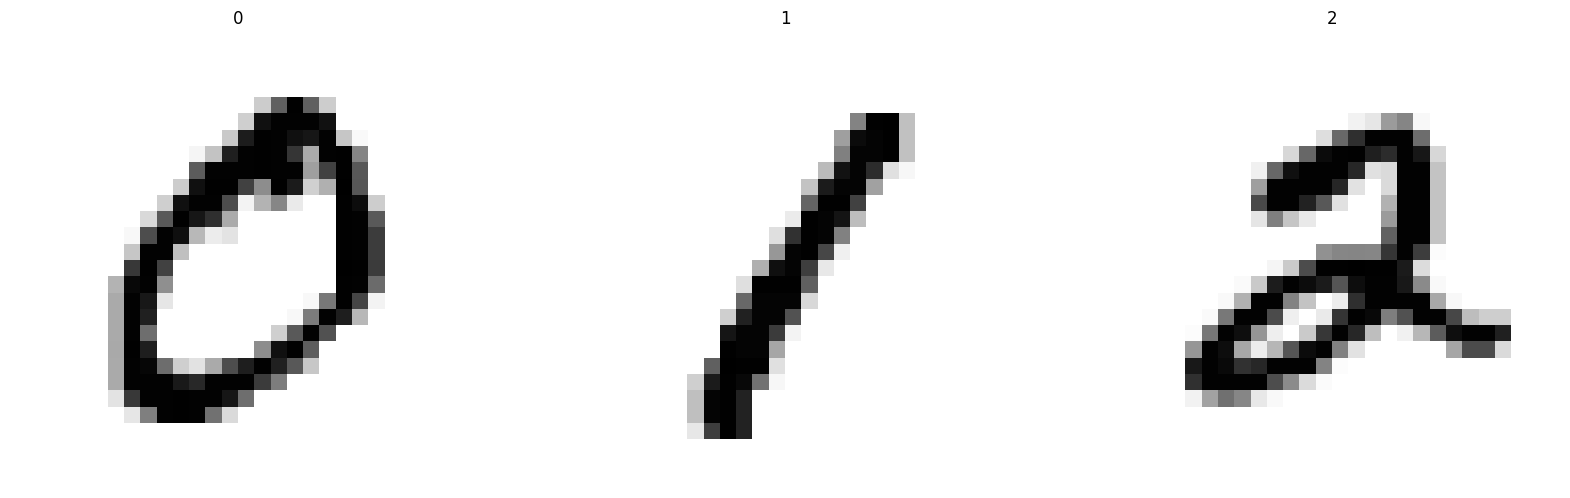

In [4]:
zero: np.ndarray = mnist.data[mnist.target == "0"].iloc[0].to_numpy()
one: np.ndarray = mnist.data[mnist.target == "1"].iloc[0].to_numpy()
two: np.ndarray = mnist.data[mnist.target == "2"].iloc[0].to_numpy()

filler = np.empty(2**10 - zero.shape[0])
filler.fill(0)

zero = np.hstack([zero, filler])
one = np.hstack([one, filler])
two = np.hstack([two, filler])

zero = zero / np.linalg.norm(zero)
one = one / np.linalg.norm(one)
two = two / np.linalg.norm(two)

plot_digits([zero, one, two], [0, 1, 2], "test", 28)

In [5]:
instr = QAlchemyInitialize(zero.tolist(), opt_params={'max_fidelity_loss': 0.2, 'basis_gates': ["id", "rx", "ry", "rz", "cx"]})

In [6]:
instr.definition.draw(fold=-1)

C:\Users\cncen\Documents\rymax-one\q-alchemy-sdk-py\.venv\Lib\site-packages\hypermedia_client\core\model\sirenmodels.py:96: UserWarning: Entity with extra properties received! Possibly a version mismatch between server and client? (unexpected properties: ['CreationDate'])
  warnings.warn(


┌──────────────┐                ┌────────┐┌─────────┐┌────────────┐┌─────────┐  ┌────────┐  ┌────────────┐┌─────────┐   ┌───────┐    ┌─────────┐┌────────────┐┌────────────┐ ┌─────────┐  ┌────────────┐ ┌─────────┐  ┌────────────┐                                                                      ┌───┐ ┌────────────┐ ┌─────────┐┌────────────┐ ┌─────────┐  ┌────────────┐                                            ┌───┐     ┌─────────────┐┌─────────┐ ┌────────────┐ ┌─────────┐  ┌────────────┐  ┌────────┐  ┌─────────┐┌────────────┐ ┌─────────┐   ┌──────────┐                                                                                                                                                                                                                                                  ┌───┐     ┌────────────┐┌─────────┐┌────────────┐ ┌─────────┐  ┌────────────┐               ┌───┐        ┌─────────┐    ┌─────────┐  ┌────────────┐ ┌─────────┐    ┌────────┐  ┌────────────┐┌─────────┐┌────────────┐ ┌─────────┐   ┌────────────┐                                                                                                                                                                                                               ┌───┐     ┌────────────┐┌─────────┐  ┌────────────┐┌─────────┐┌────────────┐    ┌───┐     ┌────────────┐┌─────────┐ ┌────────────┐ ┌─────────┐   ┌────────────┐    ┌────────┐    ┌─────────┐  ┌────────────┐ ┌─────────┐   ┌──────────┐                                                                                                                                                                                                                                      ┌──────────┐   ┌─────────┐  ┌────────────┐┌─────────┐  ┌──────────┐                    ┌─────────┐  ┌─────────┐   ┌────────────┐ ┌─────────┐    ┌────────┐                     ┌───────┐  ┌─────────┐  ┌────────────┐  ┌─────────┐    ┌────────┐    ┌────────┐   ┌─────────┐  ┌────────────┐ ┌─────────┐  ┌──────────┐                                             ┌───┐   ┌──────────────┐┌─────────┐┌────────────┐ ┌─────────┐  ┌────────────┐   ┌───┐    ┌────────────┐┌─────────┐┌───────────┐ ┌─────────┐   ┌────────────┐                                               ┌───┐       ┌──────────┐   ┌─────────┐   ┌────────────┐  ┌─────────┐    ┌────────┐   ┌────────┐  ┌─────────┐   ┌────────────┐ ┌─────────┐   ┌──────────┐                                        ┌─────────┐    ┌─────────┐    ┌────────────┐  ┌─────────┐    ┌────────┐                                                               ┌───────┐     ┌─────────┐   ┌───────────┐  ┌─────────┐    ┌────────┐  ┌─────────────┐┌─────────┐┌────────────┐ ┌─────────┐  ┌────────────┐                                          ┌───┐   ┌──────────────┐  ┌─────────┐    ┌────────────┐ ┌─────────┐  ┌────────────┐                        ┌───┐┌────────────┐ ┌─────────┐  ┌───────────┐  ┌─────────┐  ┌────────────┐                                        ┌───┐┌──────────────┐┌─────────┐ ┌────────────┐ ┌─────────┐  ┌────────────┐   ┌───────┐     ┌─────────┐   ┌───────────┐  ┌─────────┐    ┌────────┐                                                            ┌──────────┐  ┌─────────┐   ┌────────────┐ ┌─────────┐   ┌──────────┐                                                      ┌─────────┐ ┌─────────┐  ┌────────────┐ ┌─────────┐     ┌────────┐                                                        ┌──────────┐┌─────────┐┌────────────┐  ┌─────────┐    ┌────────┐   ┌────────┐    ┌─────────┐  ┌────────────┐ ┌─────────┐   ┌──────────┐                                    ┌──────────┐   ┌─────────┐  ┌────────────┐ ┌─────────┐   ┌──────────┐                             ┌─────────┐   ┌─────────┐  ┌────────────┐ ┌─────────┐    ┌────────┐                                 ┌───────┐     ┌─────────┐  ┌────────────┐┌─────────┐   ┌────────┐   ┌──────────────┐ ┌─────────┐  ┌────────────┐ ┌─────────┐  ┌────────────┐                             ┌───┐    ┌─

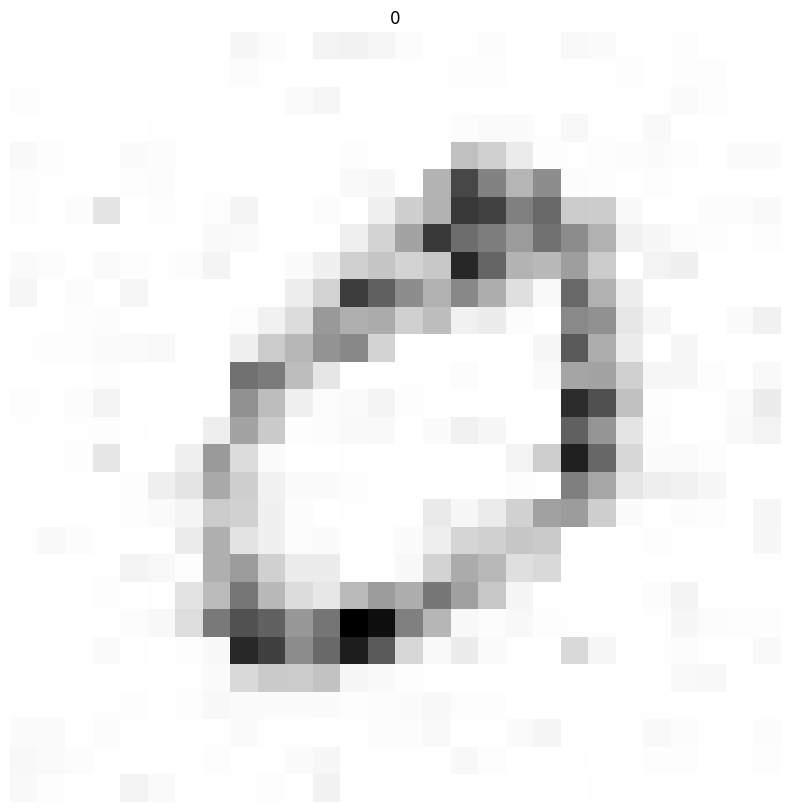

In [7]:
data = Statevector(instr.definition).data
data = np.real(data * data.conj())
plot_digits([data], [0], "test", 28)

# Looking at the 0

In [13]:
def get_comparison_data(d: np.ndarray):
    
    print("Qiskit Benchmark")
    qs_org = Initialize(d.tolist())
    qs_qc = transpile(qs_org.definition, basis_gates=["id", "rx", "ry", "rz", "cx"])
    state = Statevector(qs_qc).data.copy()
    state = np.real(state * state.conj())
    cx_length = len(qs_qc.get_instructions("cx"))
    
    threads = []
    result = [
        [-1.0, cx_length, state]
    ]
    for fidelity_loss in np.linspace(0.0, 1.0, 11):
        def func(fl):
            fl = np.round(fl, decimals=1)
            sp_org = QAlchemyInitialize(d.tolist(), opt_params={'max_fidelity_loss': fl, 'basis_gates': ["id", "rx", "ry", "rz", "cx"]})
            print(f"Starting {fl}")
            qc = sp_org.definition
            sp_length = len(qc.get_instructions("cx"))
            sp_state = Statevector(qc).data.copy()
            sp_state = np.real(sp_state * sp_state.conj())
            print(f"Done {fl}")
            result.append([fl, sp_length, sp_state])
        job = Thread(target=func, args=(fidelity_loss,))
        job.start()
        threads.append(job)

    print(f"Waiting for {len(threads)} jobs to finish.")
    for x in threads: 
        x.join()
    
    return result

In [14]:
def plot_comparison(r):
    meta_data: np.ndarray = np.asarray([r[0:2] for r in r])
    sorting = meta_data[:, 0].argsort()
    meta_data = meta_data[sorting]
    
    image_data: np.ndarray = np.asarray([r[2] for r in r])
    image_data = image_data[sorting]
    
    labels = [f"{r[0]:.1f} @ {r[1]:n}cx" for r in meta_data]
    plot_digits(image_data, labels, "test", 28)

In [15]:
result_zero = get_comparison_data(zero)

Qiskit Benchmark
Starting 0.1
Starting 0.0
Starting 0.2
Starting 0.5
Starting 0.7
Waiting for 11 jobs to finish.
Starting 0.4
Starting 0.6
Starting 0.3
Starting 0.8
Starting 0.9
Starting 1.0


C:\Users\cncen\Documents\rymax-one\q-alchemy-sdk-py\.venv\Lib\site-packages\hypermedia_client\core\model\sirenmodels.py:96: UserWarning: Entity with extra properties received! Possibly a version mismatch between server and client? (unexpected properties: ['CreationDate'])
  warnings.warn(


Done 0.6
Done 0.4
Done 0.7
Done 0.3
Done 0.1
Done 0.9
Done 0.2
Done 0.0
Done 0.8
Done 0.5


Traceback (most recent call last):
  File "C:\Users\cncen\Documents\rymax-one\q-alchemy-sdk-py\.venv\Lib\site-packages\hypermedia_client\job_management\tool\job.py", line 236, in wait_for_state
    wait_until(
  File "C:\Users\cncen\Documents\rymax-one\q-alchemy-sdk-py\.venv\Lib\site-packages\hypermedia_client\core\polling.py", line 34, in wait_until
    raise TimeoutError(
TimeoutError: : Waiting for job completion

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\cncen\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\cncen\AppData\Local\Temp\ipykernel_19176\2179146864.py", line 19, in func
  File "C:\Users\cncen\Documents\rymax-one\q-alchemy-sdk-py\.venv\Lib\site-packages\qiskit\circuit\instruction.py", line 303, in definition
    self._define()
  File "C:\Users\cncen\Documents\rymax-one\q-alchemy-sdk-py\src\q_alchemy_sdk_py

In [16]:
result_one = get_comparison_data(one)

Qiskit Benchmark
Starting 0.0Starting 0.3

Starting 0.1
Starting 0.4
Starting 0.2
Starting 0.5
Starting 0.6
Waiting for 11 jobs to finish.
Starting 0.7
Starting 0.8
Starting 0.9
Starting 1.0
Done 0.7
Done 0.4
Done 0.1
Done 0.2
Done 0.8
Done 0.9
Done 0.0
Done 0.6
Done 0.5
Done 1.0
Done 0.3


In [20]:
result_two = get_comparison_data(two)

Qiskit Benchmark
Starting 0.1Starting 0.0
Starting 0.3

Starting 0.6
Starting 0.5
Starting 0.4
Waiting for 11 jobs to finish.
Starting 0.7
Starting 0.2
Starting 0.9
Starting 0.8
Starting 1.0


C:\Users\cncen\Documents\rymax-one\q-alchemy-sdk-py\.venv\Lib\site-packages\hypermedia_client\core\model\sirenmodels.py:96: UserWarning: Entity with extra properties received! Possibly a version mismatch between server and client? (unexpected properties: ['CreationDate'])
  warnings.warn(


Done 0.5
Done 0.6
Done 0.0
Done 0.3
Done 1.0
Done 0.8
Done 0.7
Done 0.9
Done 0.1
Done 0.2
Done 0.4


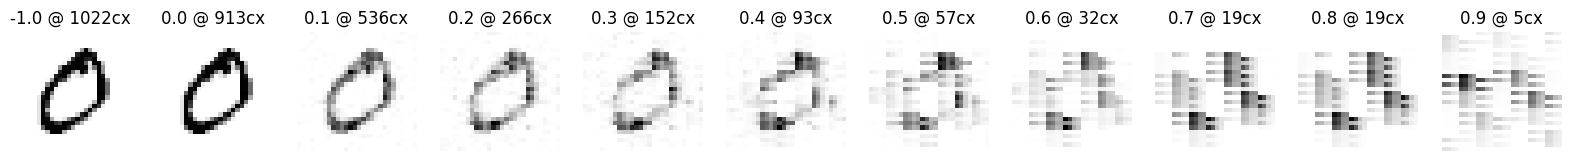

In [17]:
plot_comparison(result_zero)

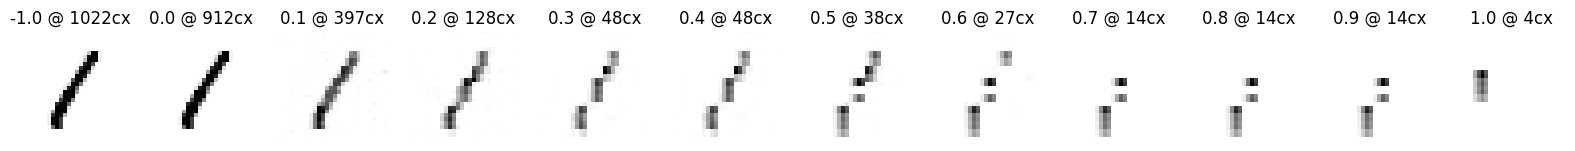

In [18]:
plot_comparison(result_one)

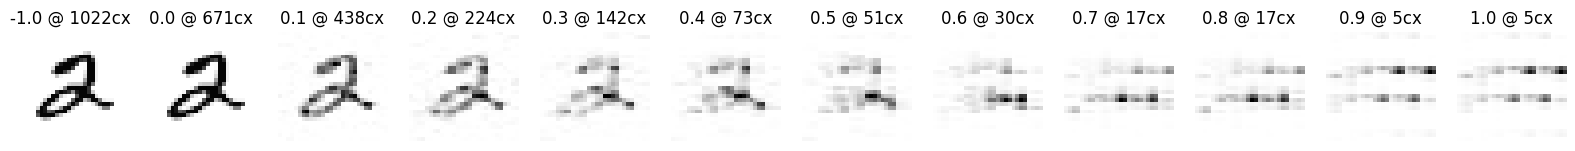

In [21]:
plot_comparison(result_two)